# Part 3 - Resampling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('tjb')

from pybaseball import statcast
import numpy as np
np.random.seed(123) # for reproducibility 
pd.options.display.max_columns = 999
import os
import sys
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Locally defined things
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/python/")
from helper_functions import scrub_stringers
from feature_builder import *

year = '2018'
saveDir = '../run/part3/'
refresh_data = False
if refresh_data:
    data = statcast(start_dt=year+'-03-29', end_dt=year+'-10-28')
    data.to_feather("../data/2018_data_raw.feather")    
else:
    data = pd.read_feather("../data/2018_data_raw.feather")

In [2]:
scrub_data = scrub_stringers(data)
targets = ["field_out", "single", "double",  "triple", "home_run"]
target_df = scrub_data[scrub_data['events'].isin(targets)]
target_df = add_spray_angle(target_df)
target_df = add_park_factors(target_df, 2017)
target_df = add_sprint_speed(target_df, 2017)

/Users/tburch/Documents/github/mlb-hit-classifier/python/feature_builder.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["spray_angle"] = np.arctan((df["hc_x"]-125.42)/(198.27-df["hc_y"]))*180/np.pi*.75
/Users/tburch/Documents/github/mlb-hit-classifier/python/feature_builder.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["adj_spray_angle"] = df .apply(lambda row: -row["spray_angle"] if row["stand"] == "L" else row["spray_angle"], axis=1)


In [3]:
# BDT parameters
def generate_params(features, bdt_kwargdict={}, task_kwargdict={}):
    bdt_param={}
    bdt_param["learning_rate"] = 0.3
    bdt_param['max_depth']        = 5  # maximum depth of a tree
    bdt_param['subsample']        = 1.0 # fraction of events to train tree on
    bdt_param['colsample_bytree'] = 1.0 # fraction of features to train tree on
    bdt_param['objective']   = 'multi:softmax' # objective function
    bdt_param['n_estimators']   = 200 
    bdt_param['num_class'] = 5
    bdt_param['feature_names'] = features

    # Learning task parameters
    task_param={}
    task_param['eval_metric'] = ['mlogloss', 'merror']           # evaluation metric for cross validation
    task_param['early_stopping_rounds'] = 30
    task_param['eval_set'] = [(X_train, y_train), (X_test,y_test)]
   
    bdt_param.update(bdt_kwargdict)
    task_param.update(task_kwargdict)
    
    
    return bdt_param, task_param

In [4]:
all_feature_cols = ['launch_speed', 'launch_angle', 'adj_spray_angle', 'spray_angle', '1b_park_factor','2b_park_factor','3b_park_factor','hr_park_factor','sprint_speed']
slim_df = target_df.loc[:, all_feature_cols+["events"]]
slim_df = slim_df.dropna()
mask = np.random.rand(len(slim_df)) < 0.50
train = slim_df[mask]
test = slim_df[~mask]

X_train = train.loc[:, all_feature_cols]
X_test = test.loc[:, all_feature_cols]

le = LabelEncoder()
le.fit(slim_df["events"])
y_train = le.transform(train["events"]) 
y_test = le.transform(test["events"])

In [5]:
def conf_matrix(true, pred, classnames):
    conf_mat = confusion_matrix(true, pred,classnames)
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=2)
    plt.tick_params(axis='both', which='major', labelsize=14)    
    plt.yticks(va="center")
    sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=classnames, yticklabels=classnames, annot_kws={"size": 14})

In [22]:
def train_bdt(X, y, features, bdt_kwargdict={}, task_kwargdict={}):
   # this_X = X[features]
    bdt_kwargdict.update({"feature_names":features})
    #task_kwargdict.update({'eval_set': [(X_train[features], y_train), (X_test[features],y_test)]})
    bdt_param, task_param = generate_params(features, bdt_kwargdict=bdt_kwargdict, task_kwargdict=task_kwargdict)
    bdt = xgb.XGBClassifier(**bdt_param)
    bdt.fit( X, y, verbose=False, **task_param)
    print(bdt)
    return bdt

### First check the impact of adjusted spray angle

This idea I saw at [Alan Nathan's blog](http://baseball.physics.illinois.edu/carry-v2.pdf), in which the sign of spray angle for lefties is flipped in order to flip it from absolute coordinates in x to push/pull in x

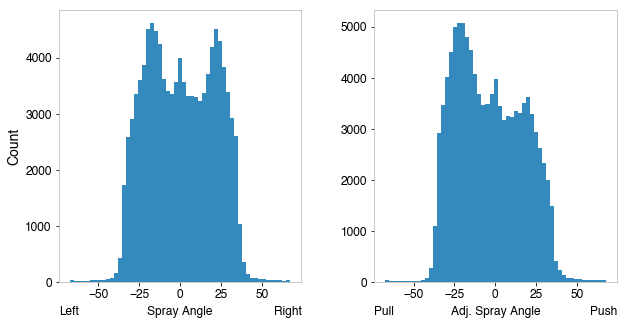

In [186]:
fig,ax_enum = plt.subplots(ncols=2,nrows=1, figsize=(10,5))
slim_df.hist("spray_angle",bins=55, ax=ax_enum[0])
ax_enum[0].set_title("")
ax_enum[0].set_xlabel("Spray Angle")
ax_enum[0].annotate("Right",xy=(1,-0.12),xycoords="axes fraction",fontsize=12,ha="right")
ax_enum[0].annotate("Left",xy=(0,-0.12),xycoords="axes fraction",fontsize=12,ha="left")
ax_enum[0].set_ylabel("Count",fontsize=14)

slim_df.hist("adj_spray_angle",bins=55, ax=ax_enum[1])
ax_enum[1].set_title("")
ax_enum[1].set_xlabel("Adj. Spray Angle")
ax_enum[1].annotate("Push",xy=(1,-0.12),xycoords="axes fraction",fontsize=12,ha="right")
ax_enum[1].annotate("Pull",xy=(0,-0.12),xycoords="axes fraction",fontsize=12,ha="left")


for ax in ax_enum:
    ax.grid(b=None)
    
plt.savefig(saveDir+"/adj_spray_angle_hist", bbox_inches='tight')

In [7]:
original_features = [x for x in all_feature_cols if x != 'adj_spray_angle']
adjusted_features = [x for x in all_feature_cols if x != 'spray_angle']
original_bdt = train_bdt(X_train, y_train, original_features)
adjusted_bdt = train_bdt(X_train, y_train, adjusted_features)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, 

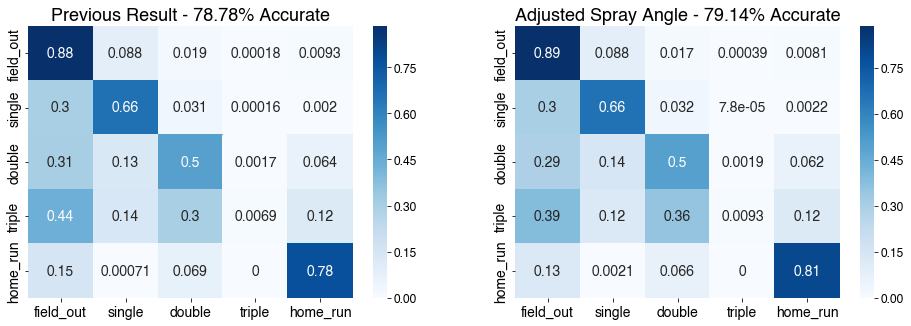

In [8]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(original_bdt.predict(X_test[original_features])), classnames=targets)
plt.title("Previous Result - {0:.2f}% Accurate".format(100*original_bdt.score(X_test[original_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Adjusted Spray Angle - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/adj_spray_angle_result", bbox_inches='tight')

In [9]:
X_train = X_train.drop("spray_angle",axis=1)
X_test = X_test.drop("spray_angle",axis=1)

Good improvement of accuracy here, specifically in HRs. Good takeaway: smart features are just as (if not more) important than smart models.

## Now to the sampling

### First we'll look at simple upsampling to the majority class

This means we'll balance out the classes by repeating events in the minority classes until that match that of the majority

In [10]:
from sklearn.utils import resample
X_train["target"] = y_train
max_size = max(np.bincount(y_train))

upsampled_df = pd.DataFrame()
for target in np.unique(y_train):
    class_samples = X_train[X_train["target"] == target]
    upsampled_class_samples = resample(class_samples, 
                                 replace=True,     # sample with replacement
                                 n_samples=max_size,    # to match majority class
                                 random_state=123) # reproducible results
    upsampled_df = pd.concat([upsampled_df, upsampled_class_samples])

In [11]:
# Check to make sure it worked...
upsampled_df["target"].value_counts()

4    33087
3    33087
2    33087
1    33087
0    33087
Name: target, dtype: int64

In [12]:
y_train_upsample = np.array(upsampled_df["target"])
X_train_upsample = upsampled_df.drop("target", axis=1)

In [23]:
upsample_bdt = train_bdt(X_train_upsample, y_train_upsample, adjusted_features, task_kwargdict={'eval_set':[(X_train_upsample, y_train_upsample), (X_test,y_test)]})

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


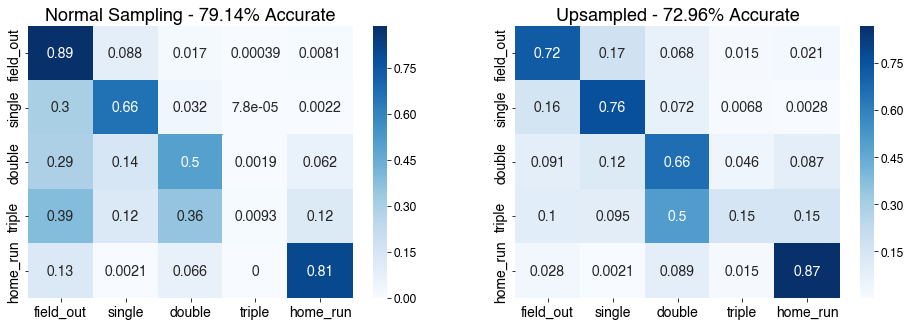

In [24]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(upsample_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Upsampled - {0:.2f}% Accurate".format(100*upsample_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/upsample_comparison", bbox_inches='tight')

Of course, as you might expect, the overall accuracy went down. Entirely due to worse performance on outs, every other class is doing better.

### Next downsampling

I'm generally not a proponent of downsampling, just because we're wasting data that we have, _especially_ when the minority class is so disproportionately low, but we can check it anyway.

In [25]:
min_size = min(np.bincount(y_train))
downsampled_df = pd.DataFrame()
for target in np.unique(y_train):
    class_samples = X_train[X_train["target"] == target]
    downsampled_class_samples = resample(class_samples, 
                                 replace=True,     # sample with replacement
                                 n_samples=min_size,    # to match majority class
                                 random_state=123) # reproducible results
    downsampled_df = pd.concat([downsampled_df, downsampled_class_samples])

In [26]:
# Check to make sure it worked...
downsampled_df["target"].value_counts()

3    421
1    421
4    421
2    421
0    421
Name: target, dtype: int64

In [29]:
y_train_downsample = np.array(downsampled_df["target"])
X_train_downsample = downsampled_df.drop("target", axis=1)
downsample_bdt = train_bdt(
    X_train_downsample, y_train_downsample, adjusted_features, 
    task_kwargdict={'eval_set':[(X_train_downsample, y_train_downsample), (X_test,y_test)]}
    )

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


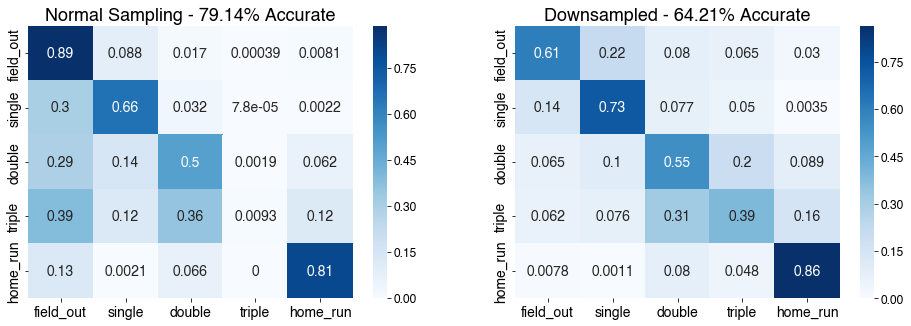

In [31]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(downsample_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Downsampled - {0:.2f}% Accurate".format(100*downsample_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/downsample_comparison", bbox_inches='tight')

This really suffered in terms of accuracy, the outs are even less accurate than the upsampled. It actually did really well with triples though, which is definitely interesting to know, but certainly makes sense.

## Trying a couple of more sophisticated resampling approaches

### Start with NearMiss

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.NearMiss.html#imblearn.under_sampling.NearMiss

In [40]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(sampling_strategy="auto")
X_train_NearMiss, y_train_NearMiss = nm.fit_resample(X_train, y_train)
np.bincount(y_train_NearMiss)

array([421, 421, 421, 421, 421])

In [42]:
X_train_NearMiss = X_train_NearMiss[adjusted_features]
NearMiss_bdt = train_bdt(
    X_train_NearMiss, y_train_NearMiss, adjusted_features, 
    task_kwargdict={'eval_set':[(X_train_NearMiss, y_train_NearMiss), (X_test,y_test)]}
    )

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


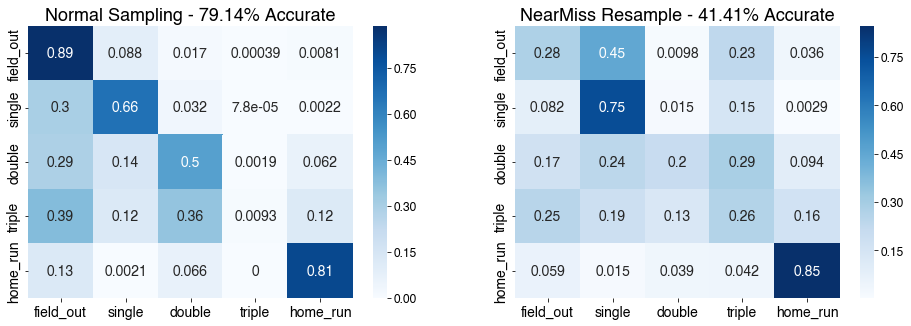

In [43]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(NearMiss_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("NearMiss Resample - {0:.2f}% Accurate".format(100*NearMiss_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/nearmiss_comparison", bbox_inches='tight')

Truly terrible. It did well for singles and home runs, I guess, but the other sampling techniques did better. Quick plot to understand why

In [49]:
nm_combined = X_train_NearMiss.copy()
nm_combined["target"] = le.inverse_transform(y_train_NearMiss)
nm_combined_outs = nm_combined[nm_combined["target"]=="field_out"]

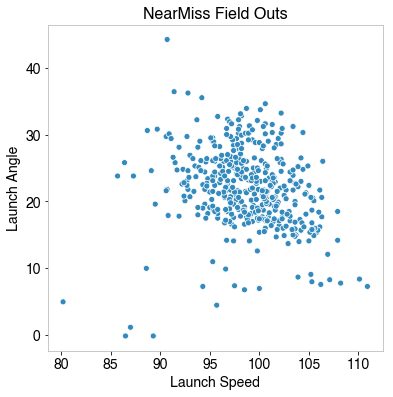

In [87]:
fig=plt.figure(figsize=(6,6))
sns.scatterplot(x='launch_speed', y='launch_angle',hue="target",
           data=nm_combined_outs,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, legend=None)
plt.xlabel("Launch Speed",fontsize=14)
plt.ylabel("Launch Angle",fontsize=14)
plt.title("NearMiss Field Outs",fontsize=16)
plt.tick_params(labelsize=14)
plt.savefig(saveDir+"/nearmiss_outs", bbox_inches='tight')

It's very obvious why this did so poorly, the field outs that it kept didn't cover the full sample space

### SMOTE

In [45]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="auto")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
np.bincount(y_train_smote)

array([33087, 33087, 33087, 33087, 33087])

In [63]:
X_train_smote = X_train_smote[adjusted_features]
smote_bdt = train_bdt(
    X_train_smote, y_train_smote, adjusted_features, 
    task_kwargdict={'eval_set':[(X_train_smote, y_train_smote), (X_test,y_test)]}
    )

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


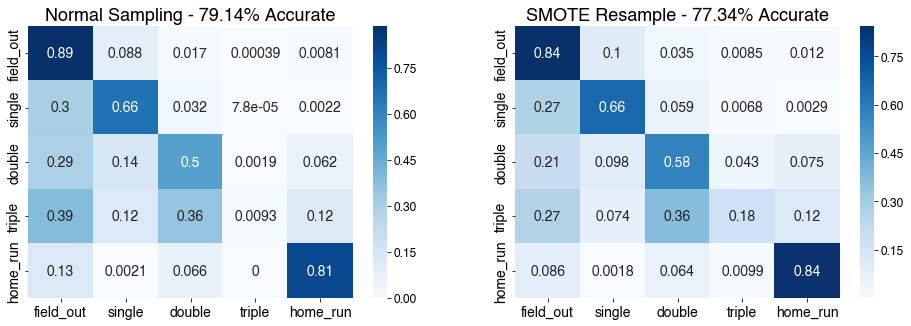

In [64]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(smote_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("SMOTE Resample - {0:.2f}% Accurate".format(100*smote_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/smote_comparison", bbox_inches='tight')

This is the best resample so far, in terms of accuracy. Everything but outs are better.

In [65]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy="auto")
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
np.bincount(y_train_adasyn)

array([32198, 33087, 33107, 33281, 33129])

In [67]:
X_train_adasyn = X_train_adasyn[adjusted_features]
adasyn_bdt = train_bdt(
    X_train_adasyn, y_train_adasyn, adjusted_features, 
    task_kwargdict={'eval_set':[(X_train_adasyn, y_train_adasyn), (X_test,y_test)]}
    )

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


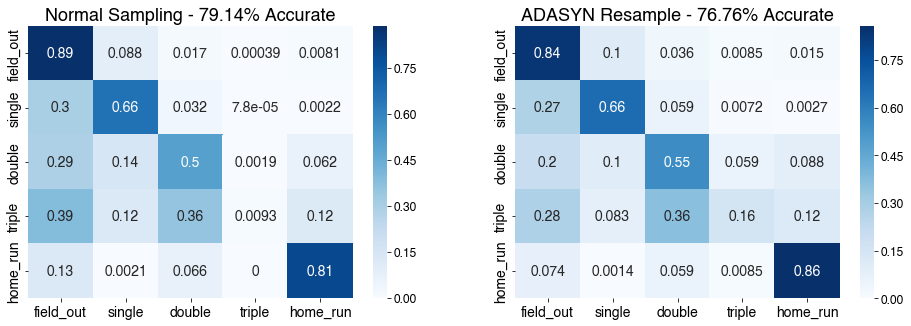

In [68]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adasyn_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("ADASYN Resample - {0:.2f}% Accurate".format(100*adasyn_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/smote_comparison", bbox_inches='tight')

A bit worse than SMOTE or normal upsampling

Next we'll make a quick comparison plot

In [89]:
from collections import OrderedDict
scores = OrderedDict()
scores["No Resampling"] =  100*adjusted_bdt.score(X_test[adjusted_features], y_test)
scores["SMOTE"] = 100*smote_bdt.score(X_test[adjusted_features], y_test)
scores["ADASYN"] =  100*adasyn_bdt.score(X_test[adjusted_features], y_test)
scores["Raw\nUpsample"] = 100*upsample_bdt.score(X_test[adjusted_features], y_test)
scores["Raw\nDownsample"] = 100*downsample_bdt.score(X_test[adjusted_features], y_test),
scores["NearMiss"] = 100*NearMiss_bdt.score(X_test[adjusted_features], y_test),

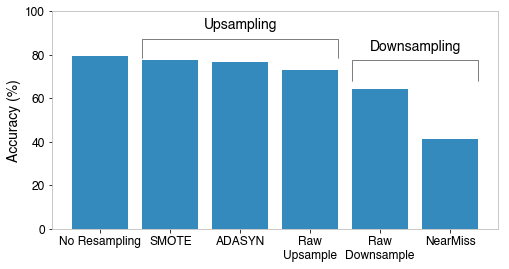

In [148]:
fig = plt.figure(figsize=(8,4))
plt.bar(scores.keys(), scores.values())
plt.ylabel("Accuracy (%)",fontsize=14)
plt.ylim(top=100)


plt.gca().annotate("",
            xy=(0.6, 60), xycoords='data',
            xytext=(3.4, 60), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="bar",
                            color="black",
                            shrinkA=40,
                            shrinkB=40,
                           ),
            )
plt.gca().annotate("Upsampling", xy=(2,92),
                   xycoords='data',ha='center',fontsize=14)


plt.gca().annotate("",
            xy=(3.6, 60), xycoords='data',
            xytext=(5.4, 60), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="bar",
                            color="black",
                            shrinkA=17,
                            shrinkB=17,
                           ),
            )
plt.gca().annotate("Downsampling", xy=(4.5,82),
                   xycoords='data',ha='center',fontsize=14)


plt.savefig(saveDir+"/single_sampling_comparison", bbox_inches='tight')

In the 1 model scenario, upsampling is the way to go for balancing. The accuracy is still worse than not resampling, however.